In [2]:
from regions import DS9Parser, read_ds9
from regions import PixCoord, CirclePixelRegion,RectanglePixelRegion, PolygonPixelRegion,EllipsePixelRegion, PolygonSkyRegion
import matplotlib.pyplot as plt
import numpy as np
import regions
from astropy.table import *
from tqdm import tqdm
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.wcs import WCS

100%|██████████| 2/2 [00:00<00:00, 117.76it/s]


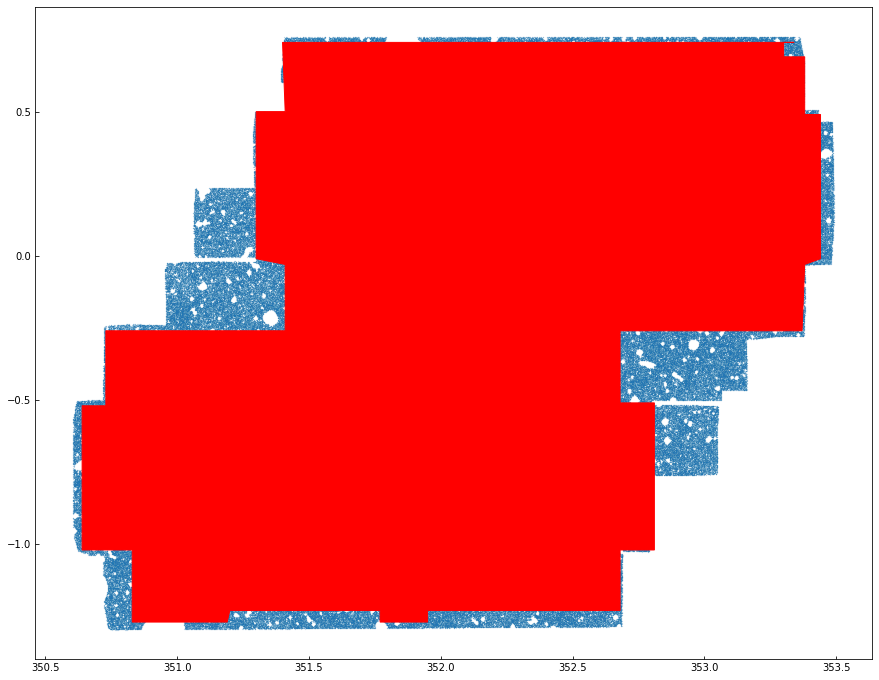

In [114]:
fig, ax = plt.subplots(figsize=(15, 12))

cat = Table.read('CUT_deep_catalogs/deep2_photoz_v2.fits')
cat = cat[cat['flag']==1]
cat = cat[cat['FLAG_FIELD_BINARY'][:,1]==True]

ax.scatter(cat['RA'],cat['DEC'],s=0.01)
file = open('uregion_test.txt')
lines = file.readlines()
for i in tqdm(range(len(lines))):
    line = lines[i]

    if ('circle' in line) or ('box' in line):
        line = 'wcs; fk5\n '+line
        region = DS9Parser(line).shapes.to_regions()[0]
        if isinstance(region, regions.shapes.circle.CircleSkyRegion):
            x = region.center.ra.value
            y = region.center.dec.value
            pixel_center = PixCoord(x=x, y=y)
            pixel_ra_axis = region.radius.value/np.cos(region.center.dec.value/180*np.pi)
            pixel_dec_axis = region.radius.value
            pixel_region = EllipsePixelRegion(pixel_center, pixel_ra_axis*2,pixel_dec_axis*2)
                
        elif isinstance(region, regions.shapes.rectangle.RectangleSkyRegion):
            x = region.center.ra.value
            y = region.center.dec.value
            pixel_center = PixCoord(x=x, y=y)
            width = region.width.value
            height = region.height.value
            angle = region.angle
            pixel_region = RectanglePixelRegion(pixel_center, width, height, angle)
        else:
            continue
                
    elif 'polygon' in line:
        line = 'wcs; fk5\n '+line
        try:
            region = DS9Parser(line).shapes.to_regions()[0]
        except ValueError:
            continue
            
        vertices = region.vertices
        pixel_vertex_x = []
        pixel_vertex_y = []
        for vertex in vertices:
            pixel_vertex_x.append(vertex.ra.value)
            pixel_vertex_y.append(vertex.dec.value)
            pixel_region = PolygonPixelRegion(vertices=PixCoord(x=pixel_vertex_x, y=pixel_vertex_y))
    
    else:
        continue
                
    artist = pixel_region.as_artist(edgecolor='r',facecolor='r',fill=True)        
    ax.add_artist(artist)

### apply mask to random point catalog

In [9]:
cat_name = 'DEEP_deep'
cat_random_name = 'CUT_deep_catalogs/'+cat_name+'_random_point_v2.fits'
cat_random = Table.read(cat_random_name)

# load region file
file = open('CUT_deep_catalogs/region_files/'+cat_name+'_mask.reg')
lines = file.readlines()

# make new column for mask flag
mask_new_column = Column(data=np.zeros(len(cat_random)),name='MASK_NEW')
cat_random.add_column(mask_new_column)
for i in tqdm(range(len(lines))):
    line = lines[i]
    line = 'wcs; fk5\n '+line
    if ('circle' in line) or ('box' in line):
        region = DS9Parser(line).shapes.to_regions()[0]
        if 'circle' in line:
            x = region.center.ra.value
            y = region.center.dec.value
            pixel_center = PixCoord(x=x, y=y)
            pixel_radius = region.radius.value
            pixel_region = CirclePixelRegion(pixel_center, pixel_radius)
            
        elif 'box' in line:
            x = region.center.ra.value
            y = region.center.dec.value
            pixel_center = PixCoord(x=x, y=y)
            width = region.width.value
            height = region.height.value
            angle = region.angle
            pixel_region = RectanglePixelRegion(pixel_center, width, height, angle)
                
        pixel_coord = PixCoord(cat_random['RA'], cat_random['DEC'])
        cat_random['MASK_NEW'] += pixel_region.contains(pixel_coord)
                
    elif 'polygon' in line:
        try:
            region = DS9Parser(line).shapes.to_regions()[0]
        except ValueError:
            continue

        vertices = region.vertices
        pixel_vertex_x = []
        pixel_vertex_y = []
        for vertex in vertices:
            pixel_vertex_x.append(vertex.ra.value)
            pixel_vertex_y.append(vertex.dec.value)
            pixel_region = PolygonPixelRegion(vertices=PixCoord(x=pixel_vertex_x, y=pixel_vertex_y))
                
        pixel_coord = PixCoord(cat_random['RA'], cat_random['DEC'])
        cat_random['MASK_NEW'] += pixel_region.contains(pixel_coord)
        
    else:
        continue

cat_random.write(cat_random_name,overwrite=True)

# make inside flag:
inside_column = Column(data=np.zeros(len(cat_random)),name='inside')
try:
    cat_random.add_column(inside_column)
except ValueError:
    cat_random.remove_column('inside')
    cat_random.add_column(inside_column)
    
clean_region = read_ds9('CUT_deep_catalogs/region_files/'+cat_name+'_uregion.reg')[0]
if 'polygon' in line:
    vertices = clean_region.vertices
    pixel_vertex_x = []
    pixel_vertex_y = []
    for vertex in vertices:
        pixel_vertex_x.append(vertex.ra.value)
        pixel_vertex_y.append(vertex.dec.value)
        pixel_region = PolygonPixelRegion(vertices=PixCoord(x=pixel_vertex_x, y=pixel_vertex_y))
                
    pixel_coord = PixCoord(cat_random['RA'], cat_random['DEC'])
    cat_random['inside'] = pixel_region.contains(pixel_coord)

cat_random.write(cat_random_name,overwrite=True)

### cut region file into 4 (one per field)

In [10]:
file = open('CUT_deep_catalogs/VeniceAndMine2.reg')
lines = file.readlines()
save_path = 'CUT_deep_catalogs/region_files/'

reg_file_COSMOS = open(save_path+'COSMOS_deep_mask.reg','w')
reg_file_ELAIS = open(save_path+'ELAIS_deep_mask.reg','w')
reg_file_DEEP = open(save_path+'DEEP_deep_mask.reg','w')
reg_file_XMM = open(save_path+'XMM-LSS_deep_mask.reg','w')

reg_file_COSMOS.write('wcs; fk5\n ')
reg_file_ELAIS.write('wcs; fk5\n ')
reg_file_DEEP.write('wcs; fk5\n ')
reg_file_XMM.write('wcs; fk5\n ')

for i in tqdm(range(len(lines))):
    line = lines[i]
    line_append = 'wcs; fk5\n '+line
    
    if ('circle' in line) or ('box' in line):
        region = DS9Parser(line_append).shapes.to_regions()[0]
        x = region.center.ra.value    
    elif 'polygon' in line:
        try:
            region = DS9Parser(line_append).shapes.to_regions()[0]
            x = region.vertices[0].ra.value
        except ValueError:
            continue
    else:
        continue

    if x>34.8 and x<37.7:
        reg_file_XMM.write(line)
    elif x>148.4 and x<151.8:
        reg_file_COSMOS.write(line)
    elif x>240.6 and x<245.0:
        reg_file_ELAIS.write(line)
    elif x>350.6 and x<353.5:
        reg_file_DEEP.write(line)

reg_file_COSMOS.close()
reg_file_ELAIS.close()
reg_file_DEEP.close()
reg_file_XMM.close()



  7%|▋         | 34867/508102 [00:27<06:15, 1258.67it/s]


 14%|█▍        | 70144/508102 [00:55<05:45, 1267.37it/s]


 21%|██        | 105146/508102 [01:22<05:18, 1267.00it/s]


 28%|██▊       | 139801/508102 [01:50<04:50, 1268.63it/s]


 34%|███▍      | 174460/508102 [02:17<04:22, 1269.75it/s]


 41%|████      | 209027/508102 [02:44<03:55, 1269.72it/s]


 48%|████▊     | 243683/508102 [03:11<03:28, 1270.21it/s]


 55%|█████▍    | 278245/508102 [03:39<03:00, 1270.08it/s]


 61%|██████▏   | 312439/508102 [04:06<02:34, 1268.53it/s]


 68%|██████▊   | 347019/508102 [04:33<02:06, 1268.54it/s]


 75%|███████▌  | 381443/508102 [05:00<01:39, 1268.09it/s]


 82%|████████▏ | 416230/508102 [05:28<01:12, 1268.88it/s]


 89%|████████▊ | 450806/508102 [05:55<00:45, 1268.58it/s]


 96%|█████████▌| 485546/508102 [06:22<00:17, 1269.01it/s]


100%|██████████| 508102/508102 [06:44<00:00, 1257.02it/s]

NameError: name 'reg_file_SXDS' is not defined

### match the central galaxies

In [34]:
import subprocess,os
save_path = 'CUT_deep_catalogs/v2_matched_centrals/'
central_path = 'CUT_deep_catalogs/total_sample_old_cat_0718/'
for cat_name in ['ELAIS_deep','DEEP_deep','COSMOS_deep','XMM-LSS_deep']:
    for z in [0.4, 0.6, 0.8]:
        additional_path = cat_name+'_'+str(z*10)+'/'
        cat = Table.read(central_path+additional_path+'isolated_'+cat_name+'_11.15_'+str(z)+'_massive_normal_params_old.positions.fits')
        print(cat_name,z,len(cat))
        cmd ='java -jar ~/stilts.jar tmatch2 in1='+central_path+additional_path+'isolated_'+cat_name+'_11.15_'+str(z)+'_massive_normal_params_old.positions.fits\
                                                      in2=CUT_deep_catalogs/'+cat_name+'_photoz_v2_cut.fits join=1and2 \
                                                      matcher=sky params=0.5 values1="RA DEC" values2="RA DEC" \
                                                      out='+save_path+'central_'+cat_name+'_'+str(z)+'.fits'
        os.system(cmd)
#         file = open('kk.txt')
#         print(file.read())
        
for cat_name in ['ELAIS_deep','DEEP_deep','COSMOS_deep','XMM-LSS_deep']:
    for z in [0.4, 0.6,  0.8]: 
        cat = Table.read(save_path+'/central_'+cat_name+'_'+str(z)+'.fits')
        print(cat_name,z,len(cat))
        cat.rename_column('RA_1','RA')
        cat.rename_column('DEC_1','DEC')
        cat.write(save_path+'/central_'+cat_name+'_'+str(z)+'.fits',overwrite=True)

ELAIS_deep 0.4 174
ELAIS_deep 0.6 208
ELAIS_deep 0.8 327
DEEP_deep 0.4 159
DEEP_deep 0.6 217
DEEP_deep 0.8 305
COSMOS_deep 0.4 162
COSMOS_deep 0.6 171
COSMOS_deep 0.8 314
XMM-LSS_deep 0.4 173
XMM-LSS_deep 0.6 166
XMM-LSS_deep 0.8 324
ELAIS_deep 0.4 173
ELAIS_deep 0.6 207
ELAIS_deep 0.8 325
DEEP_deep 0.4 158
DEEP_deep 0.6 215
DEEP_deep 0.8 295
COSMOS_deep 0.4 162
COSMOS_deep 0.6 169
COSMOS_deep 0.8 305
XMM-LSS_deep 0.4 172
XMM-LSS_deep 0.6 166
XMM-LSS_deep 0.8 320


In [78]:
for cat_name in ['ELAIS_deep','DEEP_deep','COSMOS_deep','XMM-LSS_deep']:
    print(cat_name)
    cat = Table.read('CUT_deep_catalogs/'+cat_name+'_photoz_v2_cut.fits')
    column = Column(data=np.ones(len(cat)), name='sfProb',dtype='i4')
    try:
        cat.add_column(column)
    except ValueError as e:
        print(e)
        continue
    cat.write('CUT_deep_catalogs/'+cat_name+'_photoz_v2_cut.fits',overwrite=True)

Duplicate column names
Duplicate column names


In [82]:
for cat_name in ['ELAIS_deep','DEEP_deep','COSMOS_deep','XMM-LSS_deep']:
    print(cat_name)
    cat = Table.read('CUT_deep_catalogs/v2_matched_centrals/'+'central_'+cat_name+'_'+str(z)+'.fits')
    print(len(cat.keys()))

ELAIS_deep
104
DEEP_deep
104
COSMOS_deep
106
XMM-LSS_deep
104


### make new random point catalogs

In [2]:
import random

In [7]:
cat_name = 'XMM-LSS_deep'

ra_min, ra_max = (33.5, 37.8)
dec_min, dec_max = (-6.2, -3.2)
density = 5e4   # number per square arcsec
dec_bins =np.linspace(dec_min,dec_max,100)

cat_random_point = Table(names=('RA','DEC'),dtype=('f8','f8'))
for i in tqdm(range(len(dec_bins[:-1]))):
    area = (ra_max - ra_min)*(dec_bins[i+1]-dec_bins[i])*np.cos(dec_bins[i]/180*np.pi)
    rand_p_num = int(density*area) 
    for k in range(rand_p_num):
        ra_rand = random.uniform(ra_min, ra_max)
        dec_rand = random.uniform(dec_bins[i], dec_bins[i+1])
        cat_random_point.add_row([ra_rand,dec_rand])
    
cat_random_point.write('CUT_deep_catalogs/'+cat_name+'_random_point_v2.fits',overwrite=True)


100%|██████████| 99/99 [54:35<00:00, 33.08s/it]


In [40]:
for cat_name in ['COSMOS_deep','DEEP_deep','XMM-LSS_deep','ELAIS_deep']:
    if cat_name == "COSMOS_deep":
        ra_min=148.3
        ra_max=151.9
        dec_min=0.6
        dec_max=4.0
    elif cat_name == "XMM-LSS_deep":
        ra_min=33.5
        ra_max=37.8
        dec_min=-6.2
        dec_max=-3.2
    elif cat_name == "DEEP_deep":
        ra_min=350.2
        ra_max=354.1
        dec_min=-1.7
        dec_max=1.1
    elif cat_name == "ELAIS_deep":
        ra_min=239.8
        ra_max=245.8
        dec_min=53.2
        dec_max=57.0
    else:
        print('wrong cat name')
        
    density = 5e4 * 4   # number per square arcsec\
    n = 0
    dec_bins =np.linspace(dec_min,dec_max,100)
    for i in tqdm(range(len(dec_bins[:-1]))):
        area = (ra_max - ra_min)*(dec_bins[i+1]-dec_bins[i])*np.cos(dec_bins[i]/180*np.pi)
        n += area*density
    print(cat_name, n)

100%|██████████| 99/99 [00:00<00:00, 139387.75it/s]

COSMOS_deep 2445698.369968648
DEEP_deep 2183749.879015167
XMM-LSS_deep 2570974.7843951667
ELAIS_deep 2609759.4346506502


In [68]:
cat_name = 'DEEP_deep'
cat_random_name = 'CUT_deep_catalogs/'+cat_name+'_random_point.fits'
cat_random = Table.read(cat_random_name)

# make inside flag:
inside_column = Column(data=np.zeros(len(cat_random)), name='inside')
try:
    cat_random.add_column(inside_column)
except ValueError:
    cat_random.remove_column('inside')
    cat_random.add_column(inside_column)

clean_regions = read_ds9('CUT_deep_catalogs/'+'region_files/' + cat_name + '_uregion.reg')
for clean_region in clean_regions:
    if isinstance(clean_region, regions.shapes.polygon.PolygonSkyRegion):
        print('a polygon region', clean_region)
        vertices = clean_region.vertices
        pixel_vertex_x = []
        pixel_vertex_y = []
        for vertex in vertices:
            pixel_vertex_x.append(vertex.ra.value)
            pixel_vertex_y.append(vertex.dec.value)

        pixel_region = PolygonPixelRegion(vertices=PixCoord(x=pixel_vertex_x, y=pixel_vertex_y))
        pixel_coord = PixCoord(cat_random['RA'], cat_random['DEC'])
        cat_random['inside'] += pixel_region.contains(pixel_coord)
        
cat_random.write(cat_random_name, overwrite=True)

1
a polygon region Region: PolygonSkyRegion
vertices: <SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    [(350.7479297, -1.2963812), (350.8925679, -1.2972227),
     (351.0165434, -1.2966968), (351.1611816, -1.2972227),
     (351.2644946, -1.2956045), (351.3884702, -1.2933835),
     (351.5331084, -1.2904488), (351.6777466, -1.2900701),
     (351.7810596, -1.2895968), (351.9256977, -1.2893128),
     (352.0496733, -1.2920897), (352.1943115, -1.2928241),
     (352.3389497, -1.2919024), (352.4835879, -1.2904144),
     (352.6282261, -1.2862835), (352.6775193, -1.2821444),
     (352.6874791, -1.1272449), (352.6902139, -1.0247831),
     (352.7784231, -1.0223167), (352.7891089, -0.5029769),
     (352.676189 , -0.5087824), (352.6811402, -0.2892133),
     (353.1559156, -0.2841073), (353.2894292, -0.2783179),
     (353.3673094, -0.2791347), (353.3824109, -0.1654402),
     (353.3824109, -0.0830809), (353.4101564, -0.0849052),
     (353.41267  , -0.0168013), (353.483274 , -0.0168008),
     (35

In [69]:
cat_name = 'DEEP_deep'
cat_random_name = 'CUT_deep_catalogs/'+cat_name+'_random_point.fits'
cat_random = Table.read(cat_random_name)

clean_region = read_ds9('CUT_deep_catalogs/region_files/'+cat_name+'_uregion.reg')[0]
if 'polygon' in line:
    vertices = clean_region.vertices
    pixel_vertex_x = []
    pixel_vertex_y = []
    for vertex in vertices:
        pixel_vertex_x.append(vertex.ra.value)
        pixel_vertex_y.append(vertex.dec.value)
        pixel_region = PolygonPixelRegion(vertices=PixCoord(x=pixel_vertex_x, y=pixel_vertex_y))
                
    pixel_coord = PixCoord(cat_random['RA'], cat_random['DEC'])
    cat_random['inside'] = pixel_region.contains(pixel_coord)

cat_random.write(cat_random_name,overwrite=True)

In [84]:
cat_name = 'DEEP_deep'
cat_random_name = 'CUT_deep_catalogs/'+cat_name+'_random_point.fits'
cat_random = Table.read(cat_random_name)
mask_flag_list = np.zeros(len(cat_random))

# load region file
file = open('CUT_deep_catalogs/region_files/'+cat_name+'_mask.reg')
lines = file.readlines()[-1000:]
for i in range(len(lines)):
    line = lines[i]
    print(line)
    line = 'wcs; fk5\n '+line
    if ('circle' in line) or ('box' in line):
        region = DS9Parser(line).shapes.to_regions()[0]
        if 'circle' in line:
            x = region.center.ra.value
            y = region.center.dec.value
            pixel_center = PixCoord(x=x, y=y)
            pixel_radius = region.radius.value
            pixel_region = CirclePixelRegion(pixel_center, pixel_radius)
            
        elif 'box' in line:
            x = region.center.ra.value
            y = region.center.dec.value
            pixel_center = PixCoord(x=x, y=y)
            width = region.width.value
            height = region.height.value
            angle = region.angle
            pixel_region = RectanglePixelRegion(pixel_center, width, height, angle)
                
        pixel_coord = PixCoord(cat_random['RA'], cat_random['DEC'])
        mask_flag_list += pixel_region.contains(pixel_coord)
                
    elif 'polygon' in line:
        try:
            region = DS9Parser(line).shapes.to_regions()[0]
        except ValueError:
            continue

        vertices = region.vertices
        pixel_vertex_x = []
        pixel_vertex_y = []
        for vertex in vertices:
            pixel_vertex_x.append(vertex.ra.value)
            pixel_vertex_y.append(vertex.dec.value)
            pixel_region = PolygonPixelRegion(vertices=PixCoord(x=pixel_vertex_x, y=pixel_vertex_y))
                
        pixel_coord = PixCoord(cat_random['RA'], cat_random['DEC'])
        mask_flag_list += pixel_region.contains(pixel_coord)
        
    else:
        continue

print(len(cat_random))
print(len(mask_flag_list))
print(len(mask_flag_list[mask_flag_list==0]))
np.save('CUT_deep_catalogs/mask_flag.npy',mask_flag_list)

polygon(351.8717476,-0.1000160554,351.8734121,-0.09377441851,351.8688351,-0.08919716244,351.8642579,-0.09377432547,351.8659222,-0.1000159922,351.8688348,-0.1029287954)

polygon(351.6033704,-0.1000120744,351.6055896,-0.09377070705,351.6004583,-0.08863879711,351.5942172,-0.09085785345,351.5879761,-0.09252211375,351.5854796,-0.09377034567,351.5817349,-0.09751510532,351.5804866,-0.1000116334,351.5817348,-0.1012599343,351.5879757,-0.1037566135,351.5917204,-0.1000118519,351.594217,-0.09668315522,351.5975454,-0.1000119637,351.6004578,-0.1029246747)

polygon(352.96235,-0.09376840722,352.9611017,-0.09127193416,352.9606855,-0.08752719398,352.9548606,-0.08228465418,352.9496186,-0.08752740948,352.9494524,-0.09376867664,352.9548613,-0.09917765488,352.9611019,-0.09501668331)

polygon(352.690239,-0.09377308392,352.6877423,-0.08753155598,352.686494,-0.08628325921,352.6839975,-0.08753160202,352.6802527,-0.091276588,352.6790045,-0.09377323155,352.6802528,-0.09502152911,352.6864943,-0.09751807187)

polyg

polygon(351.2807623,-0.06255884852,351.2813569,-0.0563179447,351.2796932,-0.05007700918,351.2759493,-0.04633241539,351.2697093,-0.04550021303,351.2651331,-0.05007679706,351.2634689,-0.05340524114,351.2605567,-0.05631760363,351.2634686,-0.05923006317,351.2643004,-0.06255854933,351.2697081,-0.06796742496,351.2759482,-0.06737317584)

polygon(350.9997453,-0.06255303266,350.9951704,-0.05797668681,350.9889314,-0.0596406335,350.9860197,-0.06255271005,350.988931,-0.0654649247,350.9951698,-0.06712916579)

polygon(350.9435961,-0.06255169024,350.944262,-0.05631150253,350.9390219,-0.05048721125,350.9377742,-0.05007117427,350.9327836,-0.04632697365,350.9290402,-0.05007100186,350.9265446,-0.05131898366,350.9215534,-0.05631099846,350.9228007,-0.06255117781,350.9265435,-0.06629536844,350.932782,-0.06795957965,350.9390207,-0.06712772028)

polygon(353.2444091,-0.05631672656,353.2431608,-0.05007598891,353.2419128,-0.04882785624,353.2356727,-0.04494480389,353.2305425,-0.05007618323,353.2310975,-0.05631695

polygon(352.6440508,-0.01887467618,352.645715,-0.01263311297,352.6428023,-0.009720390069,352.6365608,-0.007223772499,352.6311517,-0.01263313504,352.6328162,-0.01887470211,352.6365612,-0.02261963541,352.6428026,-0.0201229919)

polygon(352.1651075,-0.01887513744,352.1684365,-0.01388175629,352.1696848,-0.01263341143,352.1696849,-0.006391687667,352.1684365,-0.005143343201,352.1621948,-0.0008157505601,352.155953,-0.003478882594,352.1530402,-0.006391684227,352.1530402,-0.01263340609,352.155953,-0.01554621222,352.1592819,-0.01887513493,352.1621947,-0.02178794352)

polygon(352.0361118,-0.01887503622,352.0311185,-0.01388167331,352.0248768,-0.0132991097,352.0193009,-0.01887501599,352.0248767,-0.02445093919,352.0311184,-0.02386838997)

polygon(351.6470608,-0.01887415155,351.6487253,-0.01263273867,351.6441486,-0.008055694134,351.6395716,-0.01263271751,351.6412357,-0.01887413169,351.6441482,-0.02178680263)

polygon(351.150045,-0.01887175539,351.1478269,-0.01263110698,351.1449153,-0.009718802721,351

polygon(353.1097596,0.01233189636,353.1046285,0.01746337608,353.0994979,0.01233193133,353.104629,0.007200448556)

polygon(353.0933963,0.01233195193,353.0971401,0.01857291893,353.0933957,0.0248139188,353.0921475,0.02606212316,353.0859071,0.02772643051,353.0829951,0.02481398788,353.0796671,0.02231760895,353.075923,0.01857302468,353.0796674,0.01482840172,353.0821637,0.0123319895,353.0859081,0.008587375858,353.0921483,0.01108375798)

polygon(352.9515283,0.01233239155,352.9486159,0.01524496313,352.9452873,0.01857361966,352.9423749,0.02148619696,352.9394626,0.01857364394,352.9372439,0.01233243162,352.9423754,0.007200748546,352.9486161,0.00941983541)

polygon(352.523381,0.01857488175,352.5179716,0.02398429582,352.5125623,0.01857490087,352.5179718,0.01316548335)

polygon(352.1634432,0.01857516232,352.1659399,0.02481686369,352.1621949,0.02856188025,352.1559531,0.02606519935,352.1547048,0.0248168595,352.1559531,0.02232018074,352.1596981,0.01857516138,352.1621948,0.01732682135)

polygon(351.82764

polygon(353.0901498,0.04353686928,353.0908983,0.04977782501,353.0859058,0.05477066521,353.0796655,0.05502039447,353.0744239,0.04977804162,353.0748521,0.04353704534,353.0796663,0.03872251407,353.0859066,0.03929305392)

polygon(352.2907747,0.04354191313,352.2882779,0.04978359436,352.2870296,0.05103193084,352.2845329,0.04978359838,352.2807879,0.04603859506,352.2795395,0.04354192363,352.2807879,0.04229358596,352.2870296,0.03979690687)

polygon(352.2150416,0.04354195148,352.2121288,0.04791113004,352.2083838,0.04978363403,352.2058871,0.0510319696,352.2046387,0.04978363352,352.200755,0.04354195018,352.2058871,0.03840989664,352.2121288,0.04062916422)

polygon(352.0175262,0.04354169356,352.015307,0.04978333029,352.0123943,0.05269608549,352.0094815,0.04978331234,352.0061525,0.04645442846,352.0032397,0.04354165484,352.0061525,0.04062889627,352.0123941,0.03840965963)

polygon(351.8552451,0.04354109444,351.8501134,0.04867301284,351.8449814,0.0435410448,351.8501132,0.03840912309)

polygon(351.414488

polygon(351.2688081,0.07474006149,351.2688085,0.08098085242,351.2634764,0.08631375349,351.2576105,0.08098058869,351.2572359,0.07723611866,351.2559878,0.07473978267,351.2572357,0.07349165526,351.2634755,0.06940690985)

polygon(350.9248902,0.07473128571,350.9248907,0.0809713413,350.9203161,0.08554722361,350.9157408,0.08097104842,350.9157404,0.07473101546,350.920315,0.07015511443)

polygon(353.3134528,0.08097715646,353.3105409,0.08388947851,353.3043012,0.08610850803,353.2991713,0.08097753995,353.3043019,0.07584629326,353.3105412,0.07806499024)

polygon(352.616725,0.08099000041,352.611593,0.08612195332,352.6064613,0.08099010011,352.6115932,0.07585814359)

polygon(352.5957815,0.0809902011,352.5928687,0.08390293656,352.5866272,0.08556740121,352.5820502,0.0809903268,352.5866274,0.07641316624,352.5928688,0.07807751837)

polygon(352.1526244,0.08099191046,352.1551211,0.08723355764,352.1526245,0.09347518985,352.1553292,0.09971682504,352.1526245,0.1059584429,352.1497117,0.1088711915,352.1467989,0.

polygon(352.5021582,0.1121987627,352.5043773,0.1184402788,352.4992453,0.123572259,352.4941134,0.1184403825,352.4963327,0.1121988185,352.4992455,0.1092860695)

polygon(351.8240394,0.1121974701,351.8243169,0.1184389376,351.8226527,0.1246803692,351.8189079,0.1284251805,351.8126666,0.1296733698,351.8076733,0.1246801394,351.806425,0.123253505,351.8016101,0.118438605,351.8026799,0.1121971741,351.8064247,0.1084523538,351.812666,0.1067880479,351.8189074,0.1070655283)

polygon(351.2243744,0.1121832332,351.2249294,0.1184239217,351.2197992,0.1235549411,351.2148074,0.1246642,351.2135596,0.1259122796,351.20732,0.1292403698,351.2027439,0.1246637371,351.2044075,0.1184231781,351.2073192,0.1155109886,351.2135589,0.1140550587,351.2143076,0.1121828893,351.2197983,0.1076065889)

polygon(350.8857988,0.112169767,350.8891261,0.1146658897,350.8928694,0.118410024,350.8891268,0.1234017805,350.8872554,0.1246496691,350.8828888,0.1275614002,350.8799774,0.1246493,350.8772736,0.1184092734,350.8799764,0.1121695012,35

polygon(352.84002,0.1433997176,352.8425163,0.146728296,352.8454287,0.1496407766,352.8425161,0.1540097016,352.8418919,0.1558820797,352.8362749,0.1606968865,352.830034,0.1571306691,352.8287858,0.1558824629,352.8262897,0.1496413143,352.8300344,0.1458964768,352.8325309,0.1433999194,352.8362756,0.1396550849)

polygon(352.6916197,0.1434032596,352.6864879,0.1485351592,352.6813563,0.143403469,352.6864881,0.1382715653)

polygon(352.6233256,0.1434045664,352.6240745,0.1452769807,352.6269871,0.1496459216,352.6240744,0.1525586365,352.6231664,0.1558874072,352.6226475,0.1621288245,352.6178326,0.1669437169,352.6165843,0.1683703479,352.6115911,0.1733635689,352.6053497,0.173363697,352.5991083,0.171283354,352.5961957,0.1683707523,352.5935804,0.1621293821,352.5934914,0.155887955,352.5936995,0.1496465146,352.5991089,0.1437454233,352.5997331,0.1434049705,352.6053504,0.1385900489,352.6115919,0.1388277156,352.6178333,0.1388276113)

polygon(352.4731691,0.1434067232,352.473169,0.1496482393,352.468037,0.15478020

polygon(352.097282,0.1808570515,352.093537,0.1846019335,352.0872954,0.1858501896,352.082302,0.1808569442,352.0872953,0.1758637676,352.093537,0.1771121151)

polygon(352.0465166,0.1808566377,352.0487359,0.1870981569,352.043604,0.1922299966,352.0373624,0.1925073302,352.0311207,0.1916750648,352.0265435,0.1870979264,352.0311206,0.1816054637,352.0323689,0.1808564971,352.0373622,0.1771116472,352.0436038,0.1779439083)

polygon(350.9061826,0.1808099298,350.9078463,0.1824740206,350.9124215,0.1870502777,350.9129765,0.1932902092,350.9078475,0.1984203728,350.9067385,0.1995295936,350.9016095,0.2046597221,350.8953712,0.2046592081,350.8896004,0.1995282165,350.8891325,0.1992785859,350.8835176,0.1932879163,350.8835171,0.1870481002,350.8838909,0.1808083029,350.8891307,0.1755672162,350.895369,0.1751932672,350.9016074,0.1762336875)

polygon(353.3655792,0.1870615904,353.3604488,0.1921928259,353.3553191,0.1870622573,353.3604495,0.1819310173)

polygon(352.5849608,0.1870951947,352.5832962,0.1933366225,352.5803

polygon(353.2719868,0.212029272,353.2697679,0.218269859,353.2668559,0.2211822651,353.2639443,0.2182702644,353.2606167,0.2149422537,353.257705,0.2120302358,353.260617,0.209117825,353.2668567,0.2068985824)

polygon(352.747234,0.2120560338,352.7455695,0.2182973103,352.7426569,0.2212099791,352.7397444,0.2182975127,352.7380803,0.2120563428,352.7426573,0.2074792863)

polygon(352.5391896,0.21206172,352.5429344,0.2158064732,352.5441826,0.2183029983,352.5429343,0.2195513005,352.5366928,0.2220479852,352.532948,0.2183032362,352.5354447,0.2120617967,352.536693,0.2108134928)

polygon(352.4673704,0.2120630338,352.4617945,0.2176387962,352.455553,0.214975886,352.4526403,0.212063262,352.4555531,0.2091505479,352.4617947,0.2064874399)

polygon(351.8850689,0.212061383,351.8825724,0.2183027006,351.8813241,0.2195509456,351.8788275,0.2183026161,351.8750826,0.2145577116,351.8738342,0.2120611358,351.8750825,0.2108128892,351.8813239,0.2083164744)

polygon(351.2851151,0.2120367732,351.287445,0.2182775654,351.282

KeyboardInterrupt: 

In [86]:
file = open('CUT_deep_catalogs/region_files/'+cat_name+'_mask.reg')
lines = file.readlines()

box_count = 0
circle_count = 0
polygon_count = 0
for line in lines:
    if 'box' in line:
        box_count += 1
    elif 'circle' in line:
        circle_count += 1
    elif 'polygon' in line:
        polygon_count += 1

print(box_count,circle_count,polygon_count)

40246 20174 2336


In [21]:
file = open('CUT_deep_catalogs/region_files/XMM-LSS_deep_uregion.reg')
file_new = open('CUT_deep_catalogs/region_files/XMM-LSS_deep_uregion_new.reg','w')

lines = file.readlines()
for i in range(len(lines)):    
    line = lines[i]
    if 'box' in line:
        line = 'wcs; fk5\n '+line
        region = DS9Parser(line).shapes.to_regions()[0]
        x = region.center.ra.value
        y = region.center.dec.value
        pixel_center = PixCoord(x=x, y=y)
        width = region.width.value / 3600
        height = region.height.value / 3600
        angle = region.angle.value
        new_line = 'box('+str(x)+','+str(y)+','+str(width)+'d,'+str(height)+'d,'+str(angle)+')\n'
    else:
        new_line = line
        
    file_new.write(new_line)

file.close()
file_new.close()

### check that random point catalogs are uniform

(array([  1.,   0.,   0.,   0.,   0.,   0.,   2.,   4.,   0.,   5.,   3.,
          2.,   1.,   0.,   1.,   4.,   4.,   4.,   1.,   3.,  19., 238.,
        456., 232.,  20.]),
 array([ 484. ,  532.4,  580.8,  629.2,  677.6,  726. ,  774.4,  822.8,
         871.2,  919.6,  968. , 1016.4, 1064.8, 1113.2, 1161.6, 1210. ,
        1258.4, 1306.8, 1355.2, 1403.6, 1452. , 1500.4, 1548.8, 1597.2,
        1645.6, 1694. ]),
 <a list of 25 Patch objects>)

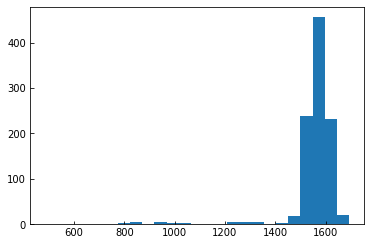

In [66]:
from random import random

#load table
num_random = []
for i in range(1000):
    cat_random = Table.read('CUT_deep_catalogs/DEEP_deep_random_point.fits')

    # choose random spot

    id_rand = int(random() * len(cat_random))
    ra_rand = cat_random[id_rand]['RA']
    dec_rand = cat_random[id_rand]['DEC']
    coord_rand = SkyCoord(ra_rand * u.deg, dec_rand * u.deg)
    coord_random_cat = SkyCoord(np.array(cat_random['RA']) * u.deg, np.array(cat_random['DEC']) * u.deg)

    # draw a circle
    cat_random_cut = cat_random[coord_random_cat.separation(coord_rand).degree < 0.05]

    # count number
    num_random.append(len(cat_random_cut))

plt.hist(num_random, bins=2)

### dealing with tract/patch definition file

In [74]:
import re

In [164]:
patch_file = open('CUT_deep_catalogs/tract_patches/tracts_patches_D-XMM-LSS.txt')

dt = np.dtype((np.float32, 2))
cat_patches = Table(names=['tract','patch','center','corner0','corner1','corner2','corner3','corner4'],
                    dtype=['a4','a4',dt,dt,dt,dt,dt,dt])
data_patch = []
prev_tract = '9999'
prev_patch = '99'
for line in patch_file.readlines():
    if ('Tract' in line) and ('Patch' in line):
        s = re.findall(r"[-+]?\d*\.\d+|\d+", line)  # find the numbers
        tract = s[0]
        patch=s[1]+s[2]
        coord = float(s[-2]),float(s[-1])
        if tract == prev_tract and patch == prev_patch:
            data_patch.append(coord)
        else:
            if len(data_patch)==8:
                cat_patches.add_row(data_patch)
            data_patch = [tract,patch,coord]
            prev_tract = tract
            prev_patch = patch
            
cat_patches.write('CUT_deep_catalogs/tract_patches/XMM-LSS_deep_patches.fits')
            

In [181]:
def find_patch(ra, dec, field='COSMOS_deep'):
    patch_list = []
    cat_patches = Table.read('CUT_deep_catalogs/tract_patches/'+field+'_patches.fits')
    for patch in cat_patches:
        if ra < patch['corner0'][0] and ra > patch['corner1'][0] and dec < patch['corner2'][1] and dec > patch['corner1'][1]:
            patch_list.append([str(patch['tract']), str(patch['patch'])])

    return patch_list

In [190]:
# add patch column
cat_random = Table.read('CUT_deep_catalogs/DEEP_deep_random_point.fits')

tract_list = []
patch_list = []
for i in tqdm(range(len(cat_random))):
    obj = cat_random[i]
    patch_data = find_patch(obj['RA'],obj['DEC'],'DEEP_deep')
    if len(patch_data) != 0:
        tract_list.append(patch_data[-1][0])
        patch_list.append(patch_data[-1][1])
    else:
        tract_list.append('9999')
        patch_list.append('99')        

tract_column = Column(name='tract',dtype='a4',data=tract_list)
patch_column = Column(name='patch',dtype='a4',data=patch_list)
cat_random.add_columns([tract_column,patch_column])
cat_random.write('CUT_deep_catalogs/DEEP_deep_random_point.fits',overwrite=True)

  0%|          | 3526/2351672 [00:56<10:24:27, 62.67it/s]

KeyboardInterrupt: 

  0%|          | 3526/2351672 [01:10<12:57:35, 50.33it/s]

### test variance maps

In [193]:
from astropy.io import fits
from astropy import wcs

In [194]:
im = '/Volumes/LejaySSD/Var/coadd_det_Deep2_MegaCam-u_var.fits'
hdulist = fits.open(im)
w = wcs.WCS(hdulist[0].header)

In [32]:
# batch download weight images

from vos import Client
directory_listing = Client().listdir('vos:clauds/tilesv4')

for i in tqdm(range(len(directory_listing))):
    file = directory_listing[i]
    if 'weight' in file:
        os.system('vcp vos:clauds/tilesv4/' + file + ' /Volumes/LejaySSD/Weight/ --verbose')

100%|██████████| 3255/3255 [2:25:10<00:00,  2.68s/it]  


### test image processing

In [41]:
from astropy.io import fits
from astropy.wcs import WCS

In [95]:
data=img[0].data
w = WCS(img[0].header)
img = fits.open('/Volumes/LejaySSD/Weight/Mega-uS_10054_0c0.weight.fits')

pix_coord = w.all_world2pix(149.55,2.9,0)
print(pix_coord[0])
data[int(pix_coord[0]),int(pix_coord[1])]

1096.3910878214047


12.853811

### make region files

In [116]:
file = open('/Users/lejay/Downloads/CLAUDS_verts/ELAIS_verts_tm.txt')
out_file = open('CUT_deep_catalogs/region_files/ELAIS_deep_uregion_tm.reg','w')
vertices = file.readlines()
out_file.write('fk5 \n')
vertices_string = ''
for vertex in vertices[:-1]:
    vertex = vertex.rstrip().split()
    vertices_string += vertex[0]+','+vertex[1]+','
    
vertex = vertices[-1].rstrip().split()
vertices_string += vertex[0]+','+vertex[1]
polygon_string = 'polygon('+vertices_string+')'
out_file.write(polygon_string)
out_file.close()
file.close()

In [259]:
t = Table.read('CUT_deep_catalogs/random_point_cat/COSMOS_deep_random_point_patches.fits')
print(len(t))
t.info()
t.add_index('tract')
type(t.loc_indices['9812'])

2445620
<Table length=2445620>
 name   dtype 
------ -------
    RA float64
   DEC float64
inside float64
  MASK float64
 tract  bytes8
 patch  bytes8
weight float32
   var float32


list

In [222]:
np.unique(t['tract'])

1005
9569
9570
9571
9572
9812
9813
9814
9999


In [261]:
t = Table(names=('a', 'b', 'c'), dtype=('f4', 'i4', 'S8'))
t.add_row((1, 2.0, 'xdffd'))
t.add_row((4, 5.0, 'y'))

In [264]:
t.add_index('a')
isinstance(t.loc_indices[1],np.int64)

True

In [30]:
cat = Table.read('CUT_deep_catalogs/v2_matched_centrals/central_COSMOS_deep_0.8.fits')
cat = cat[cat['TRACT'] == 9813]
# cat = cat[cat['PATCH'] == '0,1']

In [31]:
cat

NUMBER,RA,DEC,FIELD,TRACT,PATCH,miniNumber,MegaCam_u_EB_V_corr,MegaCam_uS_EB_V_corr,HSC_G_EB_V_corr,HSC_R_EB_V_corr,HSC_I_EB_V_corr,HSC_Z_EB_V_corr,HSC_Y_EB_V_corr,meanCorr,meanCorrErr,FLUX_TOT_MegaCam_u,FLUXERR_TOT_MegaCam_u,FLUX_TOT_MegaCam_uS,FLUXERR_TOT_MegaCam_uS,FLUX_TOT_HSC_G,FLUXERR_TOT_HSC_G,FLUX_TOT_HSC_R,FLUXERR_TOT_HSC_R,FLUX_TOT_HSC_I,FLUXERR_TOT_HSC_I,FLUX_TOT_HSC_Z,FLUXERR_TOT_HSC_Z,FLUX_TOT_HSC_Y,FLUXERR_TOT_HSC_Y,FLUX_AUTO_chi2,FLUXERR_AUTO_chi2,MU_MAX_chi2,KRON_RADIUS_chi2,FLUX_RADIUS_0.5_chi2,zKDEPeak,zKDE16,zKDEMedian,zKDE84,MAG_ABS_MegaCam_u,MAG_ABS_MegaCam_uS,MAG_ABS_HSC_G,MAG_ABS_HSC_R,MAG_ABS_HSC_I,MAG_ABS_HSC_Z,MAG_ABS_HSC_Y,AGE_BEST,AGE_MED,AGE_INF,AGE_SUP,MASS_BEST,MASS_MED,MASS_INF,MASS_SUP,SFR_BEST,SFR_MED,SFR_INF,SFR_SUP,SSFR_BEST,SSFR_MED,SSFR_INF,SSFR_SUP,LUM_NUV_BEST,LUM_R_BEST,LUM_K_BEST,CLASS_STAR_HSC_I,preds_median,u-r,r-y,sfProb_1,sfProb_nov,dzm_q,dzm_sf,inside_u,inside_uS,inside_1,ri_1,i_1,z_1,n_sat,n_bkg,RA_2,DEC_2,MASK,u,uS,g,r,i_2,z_2,y,u_err,uS_err,g_err,r_err,i_err,z_err,y_err,Z_BEST,Z_BEST68_LOW,Z_BEST68_HIGH,OBJ_TYPE,inside_2,ri_2,ID,sfProb_2,Separation
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,arcsec
int64,float64,float64,bytes6,int64,bytes3,int64,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,bool,bool,float64,float64,float64,int32,int32,float64,float64,int16,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float64,bool,float64,bytes9,int32,float64
9813740000748,149.755307832855,2.139893572762878,COSMOS,9813,"7,4",2985291,1.0826033,1.0799047,1.0644848,1.0448266,1.0319775,1.0245415,1.0209459,1.0017315629200976,0.044714005782498914,1.6597839421208964e-07,1.3250504128181884e-08,2.0890931526242064e-07,1.270108120139042e-08,1.6549551026852609e-06,9.833446560985188e-08,4.874929077518889e-06,2.3496496949290042e-07,1.660926616937715e-05,7.448106519809275e-07,2.754406137994128e-05,1.2343851815818487e-06,3.351864229249765e-05,1.519555680073182e-06,50989420.0,236305.86,-10.825097,4.0,2.4846249,0.832737953932555,0.7526618169954288,0.8666196362191729,1.365616909145004,-21.224,-21.638,-22.624000000000002,-23.245,-23.534000000000002,-23.741999999999997,-23.857,2100000000.0,4497800000.0,1921090000.0,5299560000.0,11.0672,11.2458,11.0538,11.3225,-5.80994,-4.12829,-5.74602,-3.7347099999999998,-16.8772,-15.4283,-16.8582,-15.0066,8.644630000000001,10.2622,9.70401,0.9804279208183289,0.7935262322425842,1.6069999999999993,0.6119999999999983,0.16230108381286484,0.16230108381286484,0.13944466119324506,0.06751513764277708,True,True,True,21.32227726276013,20.84912388781047,20.299930056271442,37,49,149.75530823535138,2.139895402634174,0,25.871,25.275,23.336,22.067,20.775,20.256,20.001,0.125,0.056,0.01,0.004,0.001,0.001,0.002,0.7355,0.7365,0.7413,2.0,True,21.239190288973155,022954387,1,0.006744796155373654
9813650008137,149.8620698986415,2.3954403068895744,COSMOS,9813,"6,5",3026676,1.0750614,1.0726174,1.0586418,1.0407989,1.0291203,1.0223559,1.0190835,0.9995456434213925,0.0335519483499399,2.7250989683540894e-07,1.512951363795384e-08,3.6655059621346744e-07,1.5912230939529128e-08,2.7584495310477544e-06,1.0983081375491983e-07,8.324705353224142e-06,2.8897859655721684e-07,2.7986765677731324e-05,9.42145194116777e-07,4.65394366158745e-05,1.5663176747538349e-06,5.5457543987517854e-05,1.8762046855307092e-06,91896264.0,241567.1,-11.203072,4.0,2.7222395,0.8341804941495259,0.7608170104966675,0.8390

In [14]:
from astropy.io import fits
im = 'CUT_deep_catalogs/calexp-HSC-I-9813-5,5.fits'
tract = im.split('-')[-2]
patch = im.split('-')[-1].replace('.fits', '')

In [3]:
cat = Table.read('CUT_deep_catalogs/deep2_photoz_v2.fits')

for gal in cat:
    gal['ID']  = gal['ID']
    
cat.write('CUT_deep_catalogs/deep2_photoz_v2.fits',overwrite=True)

In [6]:
np.random.randint(100,size=10)

array([58, 56,  8, 19, 59, 58, 57, 66, 14, 17])